## Instructions
1. Run all the cells sequentially. 
2. We have comments in front of each command to guide one through the details of the implementation.



## Overview

1. In this notebook, we show how to reproduce the experiments in the [paper](https://arxiv.org/pdf/2010.15234.pdf) comparing C-LRG regression to other regression methods.

2. We generate the synthetic data from the codes provided in the [IRM's repository](https://github.com/facebookresearch/InvariantRiskMinimization) 
3. Our ERM, ICP, and IRMv1 implementations are from [IRM's repository](https://github.com/facebookresearch/InvariantRiskMinimization) and can be found in models_v1.py. To ensure IRMv1 is trained only using the training domains (we use two domains in this notebook), we incorporated the training domain cross validation procedure introduced in the [paper](https://arxiv.org/pdf/2007.01434.pdf) into IRMv1.

4. In the first part of the notebook, we compare C-LRG game with regression with IRMv1, ICP, and ERM for one of the regression datasets in the [IRM paper](https://arxiv.org/pdf/1907.02893.pdf) for a fixed sample size. 

5. In the second part of the notebook, we compare C-LRG and U-LRG to illustrate why having $\ell_{\infty}$  constraints is important. Note that U-LRG game is equivalent to F-IRM game for linear models in [IRM-games paper](https://arxiv.org/pdf/2002.04692.pdf). 

6. In the last part of the notebook, we show the plots in the paper in Figure 2, C-LRG game regression with IRMv1, ICP, and ERM for different regression datasets in [IRM paper](https://arxiv.org/pdf/1907.02893.pdf) for varying sample size. 


## External libraries used
1. We use several external libraries. Please ensure you have numpy, tensorflow (version used for this notebook 1.14), matplotlib, sklearn, pandas, copy.


## Data generation 

1. We use sem.py from [IRM's repository] to generate the different datasets and further details on the sem structure can be found in the Experiments section in the [IRM paper](https://arxiv.org/pdf/1907.02893.pdf)

2. sem.py provides the flexibility to generate data from different types of structural equations

    $dim$: dimension of $X$
    
    $n_{samples}$: number of training samples

    $setup_{hetero}$ 0: heteroskedastic and 1: homoskedastic, 
    
    $setup_{hidden}$- 0: no confounders  and 1: confounded,
    
    $setup_{scramble}$ 0: no scrambling and 1: scramble with a random orthogonal matrix 
    

## IRMv1 method

We use models.py from [IRM's repository](https://github.com/facebookresearch/InvariantRiskMinimization) and add to it the training domain cross validation procedure introduced in the [paper](https://arxiv.org/pdf/2007.01434.pdf). The implementation can be found in models_v1.py

## ERM method

Since the data is generated using linear SEMs, we use the linear regression in models_v1.py


## IRM_games_regression.py explained


1. fixed_irm_game_model_regression class. Implements C-LRG game  with $\ell_{\infty}$ constraints

      A) Initialization:

       fixed_irm_game_model_regression(model_list, learning_rate, num_epochs, batch_size, bound, plot_flag)

       i) model_list: list of models for each environment; we only show results for linear models in this case

       ii) learning_rate: learning rate for SGD optimizer for training the models for each environment

       iii) batch_size: size of the batch used for each gradient update

       iv) num_epochs: number of epochs is number of training steps = number of training samples//batch size (each epoch is one full pass of the training data)

       v) bound: bound on the $\ell_{\infty}$ norm of the  $w^{\mathsf{sup}}$ 

       vi) plot_flag: if 'true' then stores model weights during training to be plotted later, else if 'false' the weights are not stored. keep it as 'false' as we currenlty only use it to illustrate why constraints is needed. 

      B) Methods:
        i) fit(data_tuple_list): takes data_tuple_list and trains the models (we fix square loss as we are in the regression setting)

       data_tuple_list- list of length equal to the number of environments, each element of the list is a tuple with three elements (data, label, environment index)  

       ii) evaluate(data_tuple_test): tuple with three elements (data_test, label_test, test environment index)

      C) Attributes:
         i) model_list: list of models for each environment

## Libraries

In [1]:
import tensorflow as tf
import numpy as np
import argparse
import IPython.display as display
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import pandas as pd
tf.compat.v1.enable_eager_execution()
import cProfile
from sklearn.model_selection import train_test_split
import copy as cp
from sklearn.model_selection import KFold
import argparse
import torch
import numpy
tf.keras.backend.set_floatx('float64')

In [2]:
## imports IRM_games_regression to fit C-LRG
from irm_games_regression import * 

In [3]:
## imports IRMv1 regression 

path_name = "../LRG_games/IRMv1_regression" #(path name to inside IRMv1_regression folder )
import sys
sys.path.insert(1, path_name)
from sem import ChainEquationModel
from models_v1 import *
from main_v1 import *

## Model Estimation Error: IRMv1  vs ERM  vs ICP vs C-LRG regression

In the cell below, we show the comparisons between IRMv1, ERM and C-LRG regression for the following setup from the experiments in Arjovsky et al. (a more extensive comparison is done towards the end of the notebook). 
We set $dim=10$, $n_{samples}=1000$, $setup_{scramble}=0$, $setup_{hidden}=0$,$setup_{hetero}=1$ and we set environment parameters as $\sigma_1=0.2$ and $\sigma_2=2.0$ 

In [5]:
## SEM parameters and IRMv1 parameters initialization
n_samples = 1000
args = {"seed":0,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 100000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":1, "setup_hidden":0, "env_list":[0.2,2.0], "verbose":0}

## Run IRMv1
args["methods"] = "IRM"
all_solutions, all_environments, msolution, sem_solution = run_experiment_IRM(args)
# print("\n".join(all_solutions))
true_sol = sem_solution.detach().numpy().T[0]
IRMv1_sol = msolution.detach().numpy().T[0]
print ("IRMv1 solution: "+ str(IRMv1_sol))
print ("Model estimation error for IRMv1: " + str(np.linalg.norm(IRMv1_sol-true_sol)**2))


args = {"seed":0,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 100000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":1, "setup_hidden":0, "env_list":[0.2,2.0], "verbose":0}

## Run ICP
args["methods"] = "ICP"
all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
# print("\n".join(all_solutions))
true_sol = sem_solution.detach().numpy().T[0]
ICP_sol = msolution.detach().numpy().T[0]
print ("ICP solution: "+ str(ICP_sol))
print ("Model estimation error for ICP: " + str(np.linalg.norm(ICP_sol-true_sol)**2))

## Run ERM
args = {"seed":0,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 100000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":1, "setup_hidden":0, "env_list":[0.2,2.0], "verbose":0}

args["methods"] = "ERM"
all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
true_sol = sem_solution.detach().numpy().T[0]
ERM_sol = msolution.detach().numpy().T[0]
print ("ERM solution: "+ str(ERM_sol))
print ("Model estimation error for ERM: " + str(np.linalg.norm(ERM_sol-true_sol)**2))

## C-LRG  parameters initialization

data_tuple_list = convert_regn_np_format(all_environments)
model_list = [] 
n_e = len(data_tuple_list)

for e in range(n_e):

    model_list.append(keras.Sequential([
            keras.layers.Dense(1)
    ]))

num_epochs       = 500
batch_size       = 128
learning_rate    = 0.005
bound            = 5
plot_flag        = 'false'
F_game = fixed_irm_game_model_regression(model_list, learning_rate, num_epochs, batch_size, bound, plot_flag) 

## Run C-LRG
F_game.fit(data_tuple_list)
fgamesol = 0.0
for e in range(n_e):
    fgamesol += F_game.model_list[e].weights[0]
print ("C-LRG game solution: "+ str(fgamesol.numpy().T[0]))
print ("Model estimation error for C-LRG game: " + str(np.linalg.norm(fgamesol.numpy().T[0]-true_sol)**2))

IRMv1 solution: [0.42090487 0.51074743 0.5162801  0.3879005  0.5134517  0.5675154
 0.59767747 0.5837838  0.6402462  0.5588348 ]
Model estimation error for IRMv1: 3.1624065984722307
ICP solution: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Model estimation error for ICP: 5.00000014682206
ERM solution: [0.3161258  0.30618998 0.3248237  0.3390036  0.27606267 0.68821037
 0.67901933 0.69738287 0.6679716  0.69450045]
Model estimation error for ERM: 4.715481484709244
C-LRG game solution: [0.99389607 0.94731999 0.94741806 0.93650211 0.92641902 0.02913765
 0.04562138 0.06772636 0.04497709 0.04224108]
Model estimation error for C-LRG game: 0.026347863990920404


## C-LRG vs U-LRG

In the cell below, we compare C-LRG with U-LRG. We show that adding constraints is critical to achieve invariance

Prediction from model 1
$Y_1 = w_{11}X_1 + w_{12}X_2$

Prediction from model 2
$Y_2 = w_{21}X_1 + w_{22}X_2$

We show a comparision of the coefficients of the models

ERM solution: [0.33915925 0.6702099 ]
Model estimation error for ERM: 0.8858918072167086
C-LRG game: [0.95620958 0.04474978]
Model estimation error for C-LRG game with constraints: 0.003920143966243537
U-LRG game solution: [0.34077142 0.67629358]
Model estimation error for U-LRG game without constraints: 0.8919553361318545


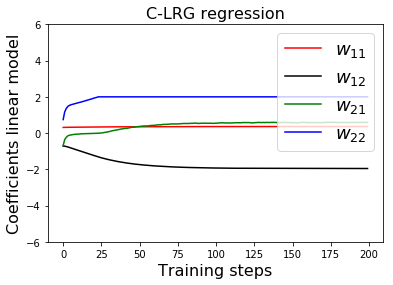

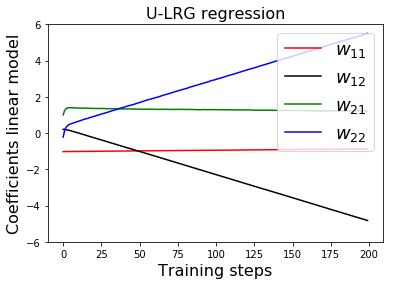

In [4]:
## SEM parameters and IRMv1 parameters initialization
n_samples = 1000
args = {"seed":0,"setup_sem": "chain", "dim": 2, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 100000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":1, "setup_hidden":0, "env_list":[0.2,2.0], "verbose":0}

## Run ERM
args["methods"] = "ERM"
all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
true_sol = sem_solution.detach().numpy().T[0]
ERM_sol = msolution.detach().numpy().T[0]
print ("ERM solution: "+ str(ERM_sol))
print ("Model estimation error for ERM: " + str(np.linalg.norm(ERM_sol-true_sol)**2))

## Constrained-LRG_games parameters initialization

data_tuple_list = convert_regn_np_format(all_environments)
model_list = [] 
n_e = len(data_tuple_list)

for e in range(n_e):

    model_list.append(keras.Sequential([
            keras.layers.Dense(1)
    ]))

num_epochs       = 200
batch_size       = 128
learning_rate    = 0.005
bound            = 2
plot_flag        = 'true'
F_game = fixed_irm_game_model_regression(model_list, learning_rate, num_epochs, batch_size, bound, plot_flag) 

## Run C-LRG game
F_game.fit(data_tuple_list)
fgamesol = 0.0
for e in range(n_e):
    fgamesol += F_game.model_list[e].weights[0]
print ("C-LRG game: "+ str(fgamesol.numpy().T[0]))
print ("Model estimation error for C-LRG game with constraints: " + str(np.linalg.norm(fgamesol.numpy().T[0]-true_sol)**2))
plt.figure()
plt.ylabel("Coefficients linear model", fontsize=16)
plt.xlabel("Training steps", fontsize=16)
plt.title("C-LRG regression", fontsize=16)
plt.plot(F_game.w1_1,  "r",label=r'$w_{11}$')
plt.plot(F_game.w1_2,  "k",label=r'$w_{12}$')
plt.plot(F_game.w2_1,  "g",label=r'$w_{21}$')
plt.plot(F_game.w2_2,  "b",label=r'$w_{22}$')
plt.legend(loc="upper right", fontsize=18)
plt.ylim(-6,6)
list_params = []
list_params.append(F_game.w1_1)
list_params.append(F_game.w1_2)
list_params.append(F_game.w2_1)
list_params.append(F_game.w2_2)
results= pd.DataFrame(list_params)

## U-LRG_games parameters initialization

data_tuple_list = convert_regn_np_format(all_environments)
model_list = [] 
n_e = len(data_tuple_list)

for e in range(n_e):

    model_list.append(keras.Sequential([
            keras.layers.Dense(1)
    ]))

num_epochs       = 200
batch_size       = 128
learning_rate    = 0.005
bound            = np.inf 
plot_flag        = 'true'
F_game = fixed_irm_game_model_regression(model_list, learning_rate, num_epochs, batch_size, bound, plot_flag) 

## Run U-LRG game
F_game.fit(data_tuple_list)
fgamesol = 0.0
for e in range(n_e):
    fgamesol += F_game.model_list[e].weights[0]
print ("U-LRG game solution: "+ str(fgamesol.numpy().T[0]))
print ("Model estimation error for U-LRG game without constraints: " + str(np.linalg.norm(fgamesol.numpy().T[0]-true_sol)**2))
plt.figure()
plt.ylabel("Coefficients linear model", fontsize=16)
plt.xlabel("Training steps", fontsize=16)
plt.title("U-LRG regression", fontsize=16)
plt.plot(F_game.w1_1,  "r",label=r'$w_{11}$')
plt.plot(F_game.w1_2,  "k",label=r'$w_{12}$')
plt.plot(F_game.w2_1,  "g",label=r'$w_{21}$')
plt.plot(F_game.w2_2,  "b",label=r'$w_{22}$')
plt.legend(loc="upper right", fontsize=18)
plt.ylim(-6,6)
list_params = []
list_params.append(F_game.w1_1)
list_params.append(F_game.w1_2)
list_params.append(F_game.w2_1)
list_params.append(F_game.w2_2)
results= pd.DataFrame(list_params)



In the cells below, we compare ERM regression, C-LRG regression, and IRMv1 regression for different SEM types, 

a)Unconfounded and homoskedastic

b)Confounded and homoskedastic

c)Unconfounded and heteroskedastic

d)Confounded and heteroskedastic


## Unconfounded and Homoskedastic (Figure 2c in the paper)

In [6]:
import time
n_trial =5
n_samples_list = [20, 100, 250, 500, 750, 1000]
k=0
K = len(n_samples_list)
MEE_irmv1 = np.zeros((K,n_trial)) # Stores model estimation error for IRMv1 for data size instance k and trial n
MEE_erm = np.zeros((K,n_trial))
MEE_firm = np.zeros((K,n_trial))
MEE_icp = np.zeros((K,n_trial))

MEE_irmv1_av = np.zeros(K) # Stores model estimation error for IRMv1 for data size instance k and trial n
MEE_erm_av = np.zeros(K)
MEE_firm_av = np.zeros(K)
MEE_icp_av = np.zeros(K)

list_params = []
for n_samples in n_samples_list:
    print ("start")
    print ("n_samples " + str(n_samples))
    
    t_start = time.time()
    for trial in range(n_trial):
        print ("trial " + str(trial))
        ## SEM parameters and IRMv1 parameters initialization
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":1, "setup_hidden":0, "env_list":[0.2,2.0], "verbose":0}

        ## Run IRMv1
        args["methods"] = "IRM"
        all_solutions, all_environments, msolution, sem_solution = run_experiment_IRM(args)
        # print("\n".join(all_solutions))
        true_sol = sem_solution.detach().numpy().T[0]
        IRMv1_sol = msolution.detach().numpy().T[0]
        msolution.detach().numpy().T[0]
        MEE_irmv1[k][trial] = np.linalg.norm(IRMv1_sol-true_sol)**2 
        
        
        ## Run ICP
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":1, "setup_hidden":0, "env_list":[0.2,2.0], "verbose":0}        
        args["methods"] = "ICP"
        all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
        # print("\n".join(all_solutions))
        true_sol = sem_solution.detach().numpy().T[0]
        ICP_sol = msolution.detach().numpy().T[0]       

        MEE_icp[k][trial] = np.linalg.norm(ICP_sol-true_sol)**2 
        
        
        
        ## Run ERM
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":1, "setup_hidden":0, "env_list":[0.2,2.0], "verbose":0}

        
        args["methods"] = "ERM"
        all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
        true_sol = sem_solution.detach().numpy().T[0]
        ERM_sol = msolution.detach().numpy().T[0]
        MEE_erm[k][trial] = np.linalg.norm(ERM_sol-true_sol)**2
        
        ## C-LRG parameters initialization

        data_tuple_list = convert_regn_np_format(all_environments)
        model_list = [] 
        n_e = len(data_tuple_list)

        for e in range(n_e):

            model_list.append(keras.Sequential([
                    keras.layers.Dense(1)
            ]))

        num_epochs       = 200
        batch_size       = 128
        learning_rate    = 0.005
        bound            = 2
        plot_flag        = 'false'
        F_game = fixed_irm_game_model_regression(model_list, learning_rate, num_epochs, batch_size, bound, plot_flag) 

        ## Run C-LRG
        F_game.fit(data_tuple_list)
        fgamesol = 0.0
        for e in range(n_e):
            fgamesol += F_game.model_list[e].weights[0]
        MEE_firm[k][trial] = np.linalg.norm(fgamesol.numpy().T[0]-true_sol)**2


    MEE_irmv1_av[k] = np.mean(MEE_irmv1[k])
    list_params.append([n_samples,"IRMv1", np.mean(MEE_irmv1[k]),np.std(MEE_irmv1[k])])

    MEE_icp_av[k] = np.mean(MEE_icp[k])
    list_params.append([n_samples,"ICP", np.mean(MEE_icp[k]),np.std(MEE_icp[k])])
    
    MEE_erm_av[k] = np.mean(MEE_erm[k])
    list_params.append([n_samples,"ERM", np.mean(MEE_erm[k]),np.std(MEE_erm[k])])

    MEE_firm_av[k] = np.mean(MEE_firm[k])
    list_params.append([n_samples,"C-LRG", np.mean(MEE_firm[k]),np.std(MEE_firm[k])])

    k=k+1

    t_end = time.time()
    print("total time: " + str(t_end-t_start))


results = pd.DataFrame(list_params, columns= ["Sample","Method", "Model estimation error", "Sdev"])
print ("end")

start
n_samples 20
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2711.1260080337524
start
n_samples 100
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2773.794326066971
start
n_samples 250
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2869.468965768814
start
n_samples 500
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2948.6228721141815
start
n_samples 750
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 3009.2672498226166
start
n_samples 1000
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 3092.9756882190704
end


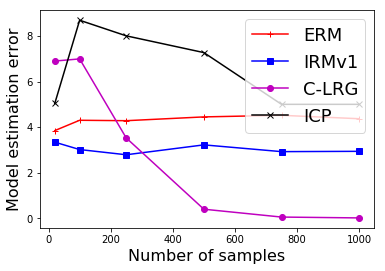

In [7]:
plt.figure()
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Model estimation error", fontsize=16)
plt.plot(n_samples_list, MEE_erm_av, "-r", marker="+", label="ERM")
plt.plot(n_samples_list, MEE_irmv1_av, "-b", marker="s",label="IRMv1")
plt.plot(n_samples_list, MEE_firm_av, "-m", marker="o",label="C-LRG") 
plt.plot(n_samples_list, MEE_icp_av, "-k", marker="x",label="ICP")
plt.legend(loc="upper right", fontsize=18)


## Confounded and Homoskedastic (Figure 2d in the paper)

In [8]:
import time
n_trial =5
n_samples_list = [20, 100, 250, 500, 750, 1000]
# n_samples_list = [10,  500,  1000]
k=0
K = len(n_samples_list)
MEE_irmv1 = np.zeros((K,n_trial)) # Stores model estimation error for IRMv1 for data size instance k and trial n
MEE_erm = np.zeros((K,n_trial))
MEE_firm = np.zeros((K,n_trial))
MEE_icp = np.zeros((K,n_trial))

MEE_irmv1_av = np.zeros(K) # Stores model estimation error for IRMv1 for data size instance k and trial n
MEE_erm_av = np.zeros(K)
MEE_firm_av = np.zeros(K)
MEE_icp_av = np.zeros(K)

list_params = []
for n_samples in n_samples_list:
    print ("start")
    print ("n_samples " + str(n_samples))
    
    t_start = time.time()
    for trial in range(n_trial):
        print ("trial " + str(trial))
        ## SEM parameters and IRMv1 parameters initialization
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":1, "setup_hidden":1, "env_list":[0.2,2.0], "verbose":0}

        ## Run IRMv1
        args["methods"] = "IRM"
        all_solutions, all_environments, msolution, sem_solution = run_experiment_IRM(args)
        # print("\n".join(all_solutions))
        true_sol = sem_solution.detach().numpy().T[0]
        IRMv1_sol = msolution.detach().numpy().T[0]
        msolution.detach().numpy().T[0]
        MEE_irmv1[k][trial] = np.linalg.norm(IRMv1_sol-true_sol)**2 
        
        
        ## Run ICP
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":1, "setup_hidden":1, "env_list":[0.2,2.0], "verbose":0}        
        args["methods"] = "ICP"
        all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
        # print("\n".join(all_solutions))
        true_sol = sem_solution.detach().numpy().T[0]
        ICP_sol = msolution.detach().numpy().T[0]       

        MEE_icp[k][trial] = np.linalg.norm(ICP_sol-true_sol)**2 
        
        
        
        ## Run ERM
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":1, "setup_hidden":1, "env_list":[0.2,2.0], "verbose":0}

        
        args["methods"] = "ERM"
        all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
        true_sol = sem_solution.detach().numpy().T[0]
        ERM_sol = msolution.detach().numpy().T[0]
        MEE_erm[k][trial] = np.linalg.norm(ERM_sol-true_sol)**2
        
        ## C-LRG parameters initialization

        data_tuple_list = convert_regn_np_format(all_environments)
        model_list = [] 
        n_e = len(data_tuple_list)

        for e in range(n_e):

            model_list.append(keras.Sequential([
                    keras.layers.Dense(1)
            ]))

        num_epochs       = 200
        batch_size       = 128
        learning_rate    = 0.005
        bound            = 2
        plot_flag        = 'false'
        F_game = fixed_irm_game_model_regression(model_list, learning_rate, num_epochs, batch_size, bound, plot_flag) 

        ## Run C-LRG
        F_game.fit(data_tuple_list)
        fgamesol = 0.0
        for e in range(n_e):
            fgamesol += F_game.model_list[e].weights[0]
        MEE_firm[k][trial] = np.linalg.norm(fgamesol.numpy().T[0]-true_sol)**2


    MEE_irmv1_av[k] = np.mean(MEE_irmv1[k])
    list_params.append([n_samples,"IRMv1", np.mean(MEE_irmv1[k]),np.std(MEE_irmv1[k])])

    MEE_icp_av[k] = np.mean(MEE_icp[k])
    list_params.append([n_samples,"ICP", np.mean(MEE_icp[k]),np.std(MEE_icp[k])])
    
    MEE_erm_av[k] = np.mean(MEE_erm[k])
    list_params.append([n_samples,"ERM", np.mean(MEE_erm[k]),np.std(MEE_erm[k])])

    MEE_firm_av[k] = np.mean(MEE_firm[k])
    list_params.append([n_samples,"C-LRG", np.mean(MEE_firm[k]),np.std(MEE_firm[k])])

    k=k+1

    t_end = time.time()
    print("total time: " + str(t_end-t_start))


results = pd.DataFrame(list_params, columns= ["Sample","Method", "Model estimation error", "Sdev"])

print ("end")

start
n_samples 20
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2765.6394901275635
start
n_samples 100
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2720.8096930980682
start
n_samples 250
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2889.3200237751007
start
n_samples 500
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2902.17275595665
start
n_samples 750
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 3002.9290471076965
start
n_samples 1000
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 3083.064390897751
end


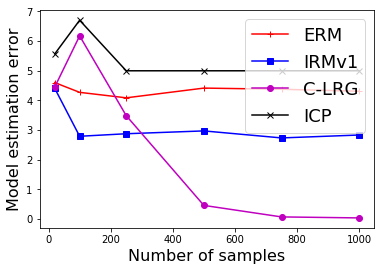

In [9]:
plt.figure()
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Model estimation error", fontsize=16)
plt.plot(n_samples_list, MEE_erm_av, "-r", marker="+", label="ERM")
plt.plot(n_samples_list, MEE_irmv1_av, "-b", marker="s",label="IRMv1")
plt.plot(n_samples_list, MEE_firm_av, "-m", marker="o",label="C-LRG")
plt.plot(n_samples_list, MEE_icp_av, "-k", marker="x",label="ICP")
plt.legend(loc="upper right", fontsize=18)


## Unconfounded and Heteroskedastic (Figure 2a in the paper)

In [10]:
import time
n_trial =5
n_samples_list = [20, 100, 250, 500, 750, 1000]
k=0
K = len(n_samples_list)
MEE_irmv1 = np.zeros((K,n_trial)) # Stores model estimation error for IRMv1 for data size instance k and trial n
MEE_erm = np.zeros((K,n_trial))
MEE_firm = np.zeros((K,n_trial))
MEE_icp = np.zeros((K,n_trial))

MEE_irmv1_av = np.zeros(K) # Stores model estimation error for IRMv1 for data size instance k and trial n
MEE_erm_av = np.zeros(K)
MEE_firm_av = np.zeros(K)
MEE_icp_av = np.zeros(K)

list_params = []
for n_samples in n_samples_list:
    print ("start")
    print ("n_samples " + str(n_samples))
    
    t_start = time.time()
    for trial in range(n_trial):
        print ("trial " + str(trial))
        ## SEM parameters and IRMv1 parameters initialization
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":0, "setup_hidden":0, "env_list":[0.2,2.0], "verbose":0}

        ## Run IRMv1
        args["methods"] = "IRM"
        all_solutions, all_environments, msolution, sem_solution = run_experiment_IRM(args)
        # print("\n".join(all_solutions))
        true_sol = sem_solution.detach().numpy().T[0]
        IRMv1_sol = msolution.detach().numpy().T[0]
        msolution.detach().numpy().T[0]
        MEE_irmv1[k][trial] = np.linalg.norm(IRMv1_sol-true_sol)**2 
        
        
        ## Run ICP
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":0, "setup_hidden":0, "env_list":[0.2,2.0], "verbose":0}        
        args["methods"] = "ICP"
        all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
        # print("\n".join(all_solutions))
        true_sol = sem_solution.detach().numpy().T[0]
        ICP_sol = msolution.detach().numpy().T[0]       

        MEE_icp[k][trial] = np.linalg.norm(ICP_sol-true_sol)**2 
        
        
        
        ## Run ERM
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":0, "setup_hidden":0, "env_list":[0.2,2.0], "verbose":0}

        
        args["methods"] = "ERM"
        all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
        true_sol = sem_solution.detach().numpy().T[0]
        ERM_sol = msolution.detach().numpy().T[0]
        MEE_erm[k][trial] = np.linalg.norm(ERM_sol-true_sol)**2
        
        ## C-LRG parameters initialization

        data_tuple_list = convert_regn_np_format(all_environments)
        model_list = [] 
        n_e = len(data_tuple_list)

        for e in range(n_e):

            model_list.append(keras.Sequential([
                    keras.layers.Dense(1)
            ]))

        num_epochs       = 200
        batch_size       = 128
        learning_rate    = 0.005
        bound            = 2
        plot_flag        = 'false'
        F_game = fixed_irm_game_model_regression(model_list, learning_rate, num_epochs, batch_size, bound, plot_flag) 

        ## Run C-LRG
        F_game.fit(data_tuple_list)
        fgamesol = 0.0
        for e in range(n_e):
            fgamesol += F_game.model_list[e].weights[0]
        MEE_firm[k][trial] = np.linalg.norm(fgamesol.numpy().T[0]-true_sol)**2


    MEE_irmv1_av[k] = np.mean(MEE_irmv1[k])
    list_params.append([n_samples,"IRMv1", np.mean(MEE_irmv1[k]),np.std(MEE_irmv1[k])])

    MEE_icp_av[k] = np.mean(MEE_icp[k])
    list_params.append([n_samples,"ICP", np.mean(MEE_icp[k]),np.std(MEE_icp[k])])
    
    MEE_erm_av[k] = np.mean(MEE_erm[k])
    list_params.append([n_samples,"ERM", np.mean(MEE_erm[k]),np.std(MEE_erm[k])])

    MEE_firm_av[k] = np.mean(MEE_firm[k])
    list_params.append([n_samples,"C-LRG", np.mean(MEE_firm[k]),np.std(MEE_firm[k])])

    k=k+1

    t_end = time.time()
    print("total time: " + str(t_end-t_start))


results = pd.DataFrame(list_params, columns= ["Sample","Method", "Model estimation error", "Sdev"])

print ("end")

start
n_samples 20
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2729.021239042282
start
n_samples 100
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2754.9137489795685
start
n_samples 250
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 3161.751237154007
start
n_samples 500
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2960.2692987918854
start
n_samples 750
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2991.936893224716
start
n_samples 1000
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 3077.4275720119476
end


<Figure size 432x288 with 0 Axes>

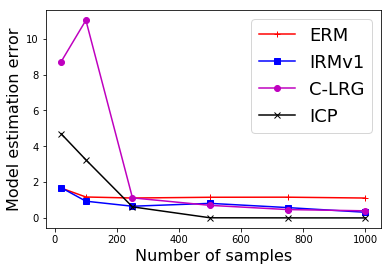

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure()
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Model estimation error", fontsize=16)
plt.plot(n_samples_list, MEE_erm_av, "-r", marker="+", label="ERM")
plt.plot(n_samples_list, MEE_irmv1_av, "-b", marker="s",label="IRMv1")
plt.plot(n_samples_list, MEE_firm_av, "-m", marker="o",label="C-LRG")
plt.plot(n_samples_list, MEE_icp_av, "-k", marker="x",label="ICP")
plt.legend(loc="upper right", fontsize=18)
plt.figure()


## Confounded and Heteroskedastic (Figure 2b in the paper)

In [12]:
import time
n_trial =5
n_samples_list = [20, 100, 250, 500, 750, 1000]
k=0
K = len(n_samples_list)
MEE_irmv1 = np.zeros((K,n_trial)) # Stores model estimation error for IRMv1 for data size instance k and trial n
MEE_erm = np.zeros((K,n_trial))
MEE_firm = np.zeros((K,n_trial))
MEE_icp = np.zeros((K,n_trial))

MEE_irmv1_av = np.zeros(K) # Stores model estimation error for IRMv1 for data size instance k and trial n
MEE_erm_av = np.zeros(K)
MEE_firm_av = np.zeros(K)
MEE_icp_av = np.zeros(K)

list_params = []
for n_samples in n_samples_list:
    print ("start")
    print ("n_samples " + str(n_samples))
    
    t_start = time.time()
    for trial in range(n_trial):
        print ("trial " + str(trial))
        ## SEM parameters and IRMv1 parameters initialization
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":0, "setup_hidden":1, "env_list":[0.2,2.0], "verbose":0}

        ## Run IRMv1
        args["methods"] = "IRM"
        all_solutions, all_environments, msolution, sem_solution = run_experiment_IRM(args)
        # print("\n".join(all_solutions))
        true_sol = sem_solution.detach().numpy().T[0]
        IRMv1_sol = msolution.detach().numpy().T[0]
        msolution.detach().numpy().T[0]
        MEE_irmv1[k][trial] = np.linalg.norm(IRMv1_sol-true_sol)**2 
        
        
        ## Run ICP
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":0, "setup_hidden":1, "env_list":[0.2,2.0], "verbose":0}        
        args["methods"] = "ICP"
        all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
        # print("\n".join(all_solutions))
        true_sol = sem_solution.detach().numpy().T[0]
        ICP_sol = msolution.detach().numpy().T[0]       

        MEE_icp[k][trial] = np.linalg.norm(ICP_sol-true_sol)**2 
        
        
        
        ## Run ERM
        args = {"seed":trial,"setup_sem": "chain", "dim": 10, "n_samples": n_samples, "n_reps": 1, "skip_reps": 0, "print_vectors": 1, "n_iterations": 50000, "lr": 1e-3, "verbose": 0,  "alpha": 0.05, "setup_scramble":0, "setup_hetero":0, "setup_hidden":1, "env_list":[0.2,2.0], "verbose":0}

        
        args["methods"] = "ERM"
        all_solutions, all_environments, msolution, sem_solution = run_experiment(args)
        true_sol = sem_solution.detach().numpy().T[0]
        ERM_sol = msolution.detach().numpy().T[0]
        MEE_erm[k][trial] = np.linalg.norm(ERM_sol-true_sol)**2
        
        ## C-LRG parameters initialization

        data_tuple_list = convert_regn_np_format(all_environments)
        model_list = [] 
        n_e = len(data_tuple_list)

        for e in range(n_e):

            model_list.append(keras.Sequential([
                    keras.layers.Dense(1)
            ]))

        num_epochs       = 200
        batch_size       = 128
        learning_rate    = 0.005
        bound            = 2
        plot_flag        = 'false'
        F_game = fixed_irm_game_model_regression(model_list, learning_rate, num_epochs, batch_size, bound, plot_flag) 

        ## Run C-LRG
        F_game.fit(data_tuple_list)
        fgamesol = 0.0
        for e in range(n_e):
            fgamesol += F_game.model_list[e].weights[0]
        MEE_firm[k][trial] = np.linalg.norm(fgamesol.numpy().T[0]-true_sol)**2


    MEE_irmv1_av[k] = np.mean(MEE_irmv1[k])
    list_params.append([n_samples,"IRMv1", np.mean(MEE_irmv1[k]),np.std(MEE_irmv1[k])])

    MEE_icp_av[k] = np.mean(MEE_icp[k])
    list_params.append([n_samples,"ICP", np.mean(MEE_icp[k]),np.std(MEE_icp[k])])
    
    MEE_erm_av[k] = np.mean(MEE_erm[k])
    list_params.append([n_samples,"ERM", np.mean(MEE_erm[k]),np.std(MEE_erm[k])])

    MEE_firm_av[k] = np.mean(MEE_firm[k])
    list_params.append([n_samples,"C-LRG", np.mean(MEE_firm[k]),np.std(MEE_firm[k])])

    k=k+1

    t_end = time.time()
    print("total time: " + str(t_end-t_start))


results = pd.DataFrame(list_params, columns= ["Sample","Method", "Model estimation error", "Sdev"])

print ("end")

start
n_samples 20
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2696.456068754196
start
n_samples 100
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2708.0110399723053
start
n_samples 250
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2771.4557781219482
start
n_samples 500
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2887.400806903839
start
n_samples 750
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 2980.669901609421
start
n_samples 1000
trial 0
trial 1
trial 2
trial 3
trial 4
total time: 3088.710032939911
end


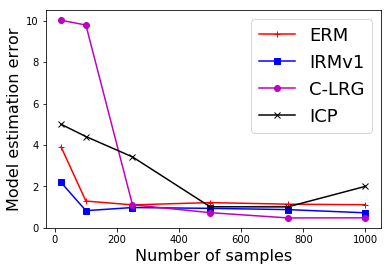

In [13]:
plt.figure()
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Model estimation error", fontsize=16)
plt.plot(n_samples_list, MEE_erm_av, "-r", marker="+", label="ERM")
plt.plot(n_samples_list, MEE_irmv1_av, "-b", marker="s",label="IRMv1")
plt.plot(n_samples_list, MEE_firm_av, "-m", marker="o",label="C-LRG")
plt.plot(n_samples_list, MEE_icp_av, "-k", marker="x",label="ICP")
plt.legend(loc="upper right", fontsize=18)
